In [1]:
import logging
import os
import random
import warnings
from datetime import datetime
from pathlib import Path
import time 
from random import SystemRandom
import pandas as pd

from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch
from torch import Tensor, jit
from utils import get_data_loaders

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
# torch.jit.enable_onednn_fusion(True)
torch.backends.cudnn.benchmark = True

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"



def MSE(y: Tensor, yhat: Tensor, mask: Tensor) -> Tensor:
    err = torch.sum(mask*((y - yhat)**2)) / torch.sum(mask)
    return err

METRICS = {
   # "RMSE": jit.script(RMSE),
    "MSE": jit.script(MSE),
    #"MAE": jit.script(MAE),
}
LOSS = jit.script(MSE)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#DEVICE = "cuda"
INPUT_DIM = 2
experiment_id = 0

print(DEVICE)
np.random.seed(0)
torch.manual_seed(0)

cpu


/home/kloetergens/miniconda3/envs/ml/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
from tsdm.tasks.mimic_iii_debrouwer2019 import mimic_collate as task_collate_fn

TRAIN_LOADER, VALID_LOADER, TEST_LOADER = get_data_loaders(
    fold=0,
    path=f"experiments/Goodwin_data/",
    observation_time=0.5,
    forecasting_horizon=0.5,
    sparsity=0.0,
    batch_size=64,
    collate_fn=task_collate_fn,
)

/home/kloetergens/projects/AFP/FLD/tsdm/utils/remote.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
from torch.optim import AdamW

EARLY_STOP = 20
OPTIMIZER_CONFIG = {
    "lr": 0.001,
    "betas": (0.9, 0.999),
    "weight_decay": 0.0001,
}

In [4]:
from src.models.FLD_debug import FLD
def predict_fn(model, batch) -> tuple[Tensor, Tensor]:
    """Get targets and predictions."""
    T, X, M, TY, Y, MY = (tensor.to(DEVICE) for tensor in batch)
    YHAT, _ = model(T, X,M,TY)
    #return torch.masked_select(Y,MY), torch.masked_select(YHAT,MY)
    return Y,YHAT, MY


def train(MODEL,OPTIMIZER,scheduler,EPOCHS):    
    N_params = sum(p.numel() for p in MODEL.parameters() if p.requires_grad)
    print(N_params)
    es = False
    best_val_loss = 10e8
    total_num_batches = 0
    for epoch in range(1, EPOCHS+1):
        loss_list = []
        start_time = time.time()
        for batch in (TRAIN_LOADER):
            total_num_batches += 1
            OPTIMIZER.zero_grad()
            Y, YHAT, MASK = predict_fn(MODEL, batch)
            R = LOSS(Y, YHAT, MASK)
            assert torch.isfinite(R).item(), "Model Collapsed!"
            loss_list.append([R])
            # Backward
            R.backward()
            OPTIMIZER.step()
        epoch_time = time.time()
        train_loss = torch.mean(torch.Tensor(loss_list))
        loss_list = []
        count = 0
        with torch.no_grad():
            for batch in (VALID_LOADER):            
                total_num_batches += 1
                Y, YHAT, MASK= predict_fn(MODEL, batch)
                R = LOSS(Y, YHAT, MASK) 
                loss_list.append([R*MASK.sum()])
                count += MASK.sum()
        val_loss = torch.sum(torch.Tensor(loss_list).to(DEVICE)/count)
        print(epoch,"Train: ", train_loss.item(), " VAL: ",val_loss.item(), " epoch time: ", int(epoch_time - start_time), 'secs')
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({'epoch': epoch,
                        'state_dict': MODEL.state_dict(),
                        'optimizer_state_dict': OPTIMIZER.state_dict(),
                        'loss': train_loss,
                        }, 'saved_models/'+"sim" + '_' + str(experiment_id) + '.h5')
            early_stop = 0
        else:
            early_stop += 1
        if early_stop == EARLY_STOP:
            print(f"Early stopping because of no improvement in val. metric for {EARLY_STOP} epochs")
            es = True 
            break
        scheduler.step(val_loss)
    
        # LOGGER.log_epoch_end(epoch)
    print("best_val_loss", best_val_loss)

In [5]:
def test(MODEL):
    chp = torch.load('saved_models/' +"sim" + '_' + str(experiment_id) + '.h5')
    MODEL.load_state_dict(chp['state_dict'])
    loss_list = []
    count = 0
    with torch.no_grad():
        for batch in (TEST_LOADER):
            #total_num_batches += 1
            # Forward
            Y, YHAT, MASK = predict_fn(MODEL, batch)
            R = LOSS(Y, YHAT, MASK)
            assert torch.isfinite(R).item(), "Model Collapsed!"
            loss_list.append([R*MASK.sum()])
            count += MASK.sum()
    test_loss = torch.sum(torch.Tensor(loss_list).to(DEVICE)/count)
    print(" test_loss : ", test_loss.item())


In [6]:
FLDL = FLD(input_dim=INPUT_DIM,latent_dim=8,embed_dim_per_head=4,num_heads=8,function="L",depth=4,device=DEVICE, hidden_dim=32).to(DEVICE)

batch = next(iter(TRAIN_LOADER))
FLDL.zero_grad(set_to_none=True)
Y, YHAT,MASK = predict_fn(FLDL, batch)
R = LOSS(Y, YHAT,MASK)
R.backward()
FLDL.zero_grad(set_to_none=True)

OPTIMIZER = AdamW(FLDL.parameters(), **OPTIMIZER_CONFIG)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(OPTIMIZER, 'min', patience=25, factor=0.5, min_lr=0.0005, verbose=True)

train(FLDL,OPTIMIZER,scheduler,10)
test(FLDL)

6026
1 Train:  0.8670395612716675  VAL:  0.8329327702522278  epoch time:  0 secs
2 Train:  0.7788082957267761  VAL:  0.7239933013916016  epoch time:  0 secs
3 Train:  0.6872386336326599  VAL:  0.6584466695785522  epoch time:  0 secs
4 Train:  0.6045187711715698  VAL:  0.5556738376617432  epoch time:  0 secs
5 Train:  0.4648137092590332  VAL:  0.4093017876148224  epoch time:  0 secs
6 Train:  0.3432515561580658  VAL:  0.30094972252845764  epoch time:  0 secs
7 Train:  0.23818539083003998  VAL:  0.20343630015850067  epoch time:  0 secs
8 Train:  0.16606591641902924  VAL:  0.14199817180633545  epoch time:  0 secs
9 Train:  0.12471853941679001  VAL:  0.11663389950990677  epoch time:  0 secs
10 Train:  0.10881796479225159  VAL:  0.09812252968549728  epoch time:  0 secs
11 Train:  0.08934374898672104  VAL:  0.08297838270664215  epoch time:  1 secs
12 Train:  0.08015403896570206  VAL:  0.10193042457103729  epoch time:  1 secs
13 Train:  0.06934719532728195  VAL:  0.06258100271224976  epoch ti

KeyboardInterrupt: 

In [ ]:
_, _, TEST_LOADER_FULL_OBS = get_data_loaders(
    fold=0,
    path=f"experiments/Goodwin_data/",
    observation_time=0.5,
    forecasting_horizon=0.5,
    sparsity=0.0,
    batch_size=64,
    collate_fn=task_collate_fn,
)

In [ ]:
batch_full_obs = next(iter(TEST_LOADER_FULL_OBS))
tx_, x_, mx_, ty_, y_, my_ = (tensor.to(DEVICE) for tensor in batch_full_obs)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

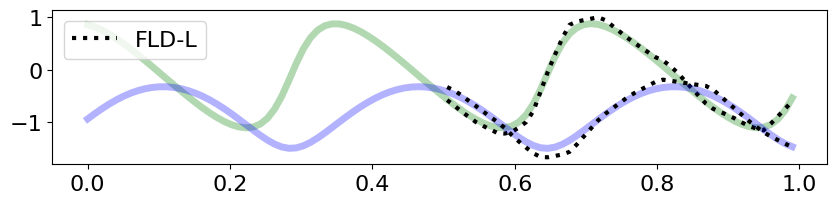

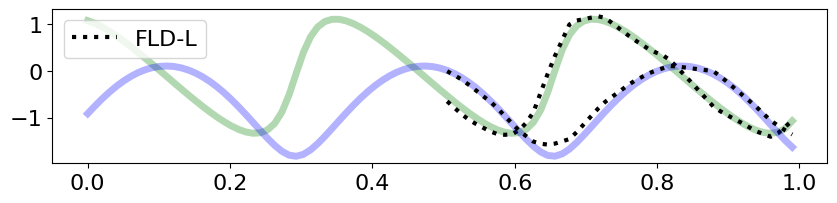

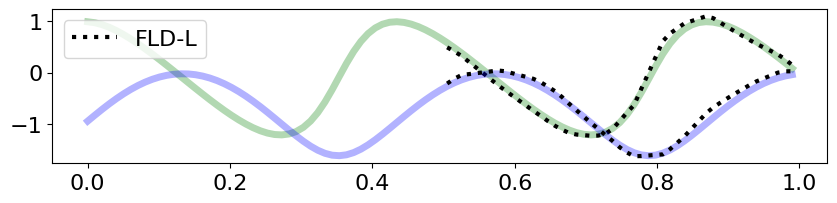

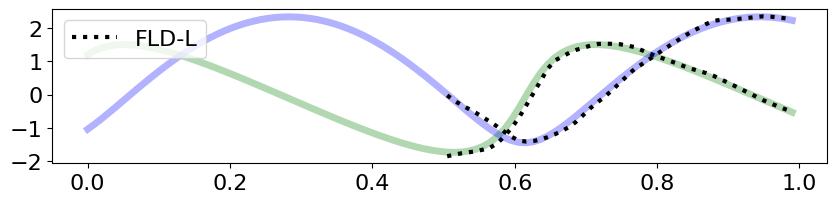

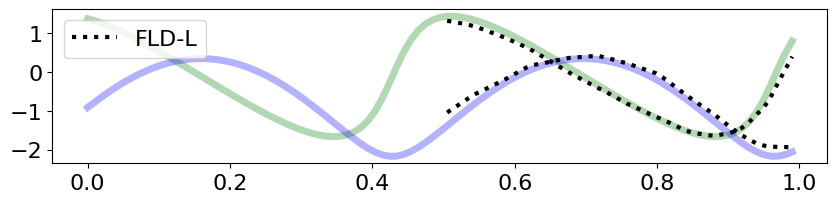

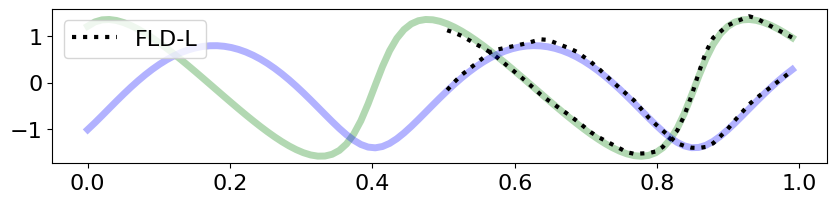

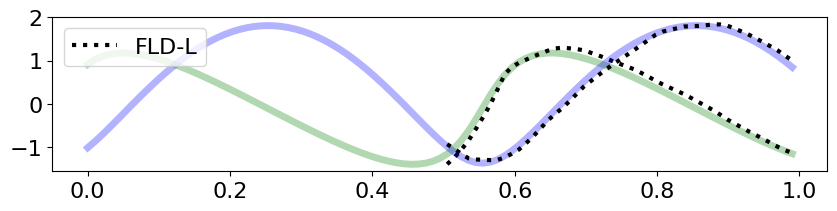

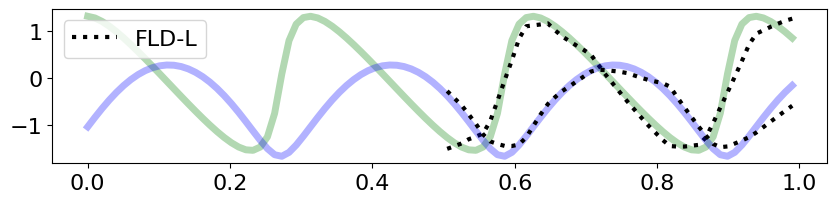

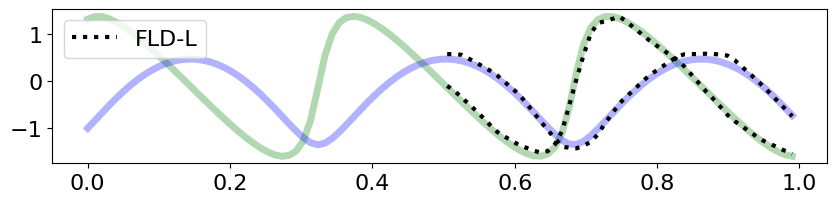

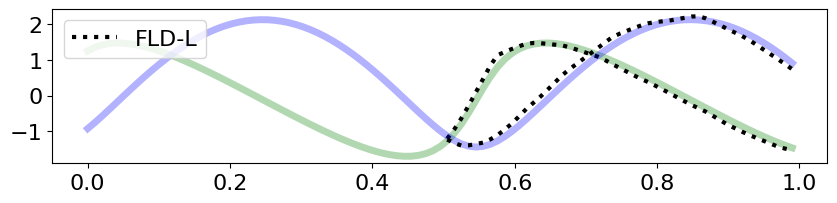

In [ ]:
from matplotlib import pyplot as plt
batch = next(iter(TEST_LOADER))

tx, x, mx, ty, y, my = (tensor.to(DEVICE) for tensor in batch)
colors = ["green","blue"]
yhat_fldl,coeffsl = FLDL(tx,x,mx,ty)
for i in range(0,10):
    plt.figure(figsize=(10,2))
    plt.cla()
    for c in range(INPUT_DIM):
        plt.legend( loc =2, prop={'size': 16})
        plt.plot(np.concatenate([tx_[i].cpu().numpy(),ty_[i].cpu().numpy()]),np.concatenate([x_[i,:,c].cpu().numpy(),y_[i,:,c].cpu().numpy()]),c=colors[c], alpha=0.3,lw=5)
       
        plt.plot(ty[i][my[i,:,c]].cpu().numpy(),yhat_fldl[i,:,c][my[i,:,c]].cpu().detach().numpy(),label="FLD-L",ls="dotted",c="black", lw=3)
        plt.yticks(fontsize=16)
        plt.xticks(fontsize=16)
        
   
    plt.savefig(f"plots/Goodwin_{i}.png",bbox_inches="tight")


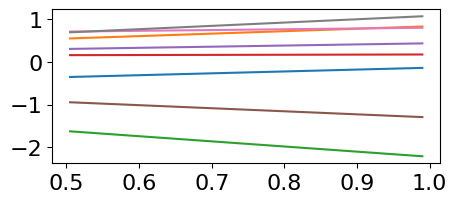

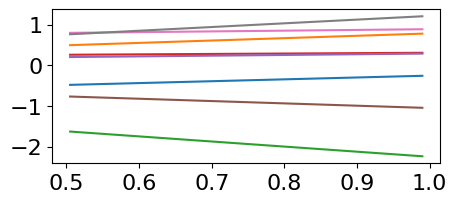

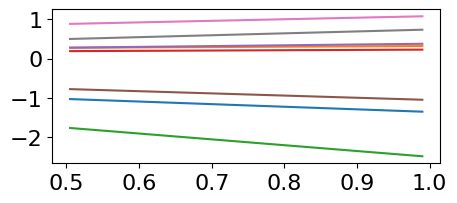

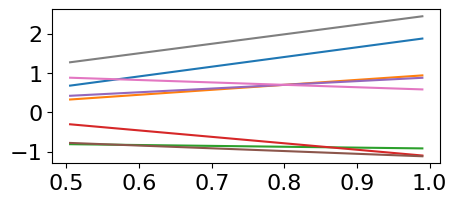

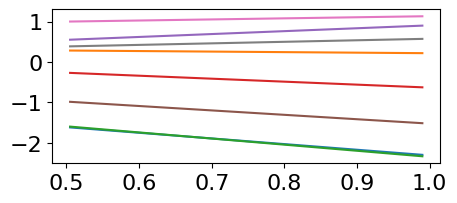

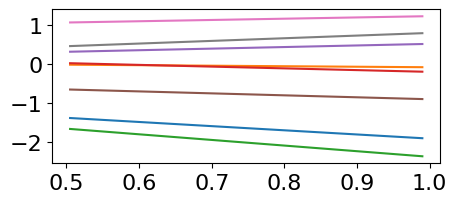

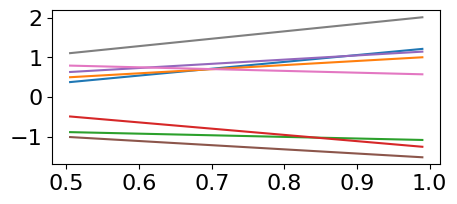

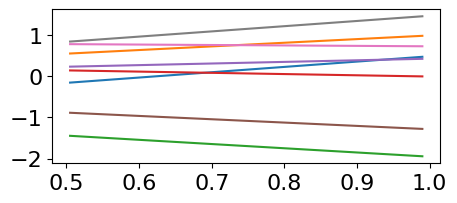

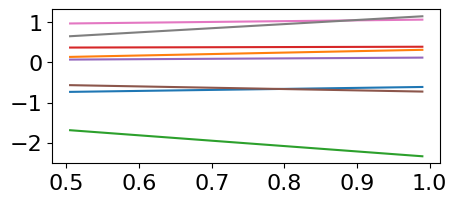

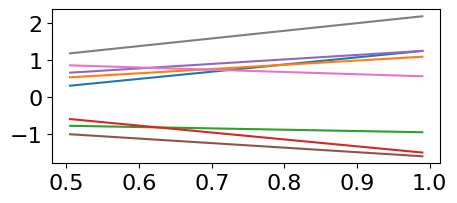

In [ ]:
for i in range(0,10):
    plt.figure(figsize=(5,2))
    plt.cla()
    x = coeffsl[i, 0, :].unsqueeze(-2) + (
        (ty_[i]).unsqueeze(-1) @ coeffsl[i, 1, :].unsqueeze(-2)
    )
    x = x.detach().cpu().numpy()
    for l in range(x.shape[1]):
        plt.plot(ty[i].cpu().numpy(),x[:,l])
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.savefig(f"plots/Goodwin_Hidden{i}.png",bbox_inches="tight")
